## INITIAL PREPARATION

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re, os, logging
from scipy import stats
from wordcloud import WordCloud
import plotly.express as px
from ydata_profiling import ProfileReport
from unidecode import unidecode

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
PLOT_DIR = "./visuals"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

In [4]:
file_path = "./Spotify_Youtube.csv"
df = pd.read_csv(file_path, encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20718 entries, 0 to 20717
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        20718 non-null  int64  
 1   Artist            20718 non-null  object 
 2   Url_spotify       20718 non-null  object 
 3   Track             20718 non-null  object 
 4   Album             20718 non-null  object 
 5   Album_type        20718 non-null  object 
 6   Uri               20718 non-null  object 
 7   Danceability      20716 non-null  float64
 8   Energy            20716 non-null  float64
 9   Key               20716 non-null  float64
 10  Loudness          20716 non-null  float64
 11  Speechiness       20716 non-null  float64
 12  Acousticness      20716 non-null  float64
 13  Instrumentalness  20716 non-null  float64
 14  Liveness          20716 non-null  float64
 15  Valence           20716 non-null  float64
 16  Tempo             20716 non-null  float6

In [5]:
# renaming 1st col
df = df.rename(columns={'Unnamed: 0': 'Index'})

df.describe()

,Index,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Stream
count,20718.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,2.071600e+04,2.024800e+04,2.017700e+04,2.014900e+04,2.071800e+04
mean,10358.500000,0.619777,0.635250,5.300348,-7.671680,0.096456,0.291535,0.055960,0.193521,0.529853,120.638340,2.247176e+05,9.393782e+07,6.633411e+05,2.751899e+04,1.339019e+08
std,5980.915774,0.165272,0.214147,3.576449,4.632749,0.111960,0.286299,0.193263,0.168531,0.245441,29.579018,1.247905e+05,2.746443e+08,1.789324e+06,1.932347e+05,2.416096e+08
min,0.000000,0.000000,0.000000,0.000000,-46.251000,0.000000,0.000000,0.000000,0.014500,0.000000,0.000000,3.098500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5179.250000,0.518000,0.507000,2.000000,-8.858000,0.035700,0.045200,0.000000,0.094100,0.339000,97.002000,1.800095e+05,1.826002e+06,2.158100e+04,5.090000e+02,1.739400e+07
50%,10358.500000,0.637000,0.666000,5.000000,-6.536000,0.050500,0.193000,0.000000,0.125000,0.537000,119.965000,2.132845e+05,1.450110e+07,1.244810e+05,3.277000e+03,4.898728e+07
75%,15537.750000,0.740250,0.798000,8.000000,-4.931000,0.103000,0.477250,0.000500,0.237000,0.726250,139.935000,2.524430e+05,7.039975e+07,5.221480e+05,1.436000e+04,1.358066e+08
max,20717.000000,0.975000,1.000000,11.000000,0.920000,0.964000,0.996000,1.000000,1.000000,0.993000,243.372000,4.676058e+06,8.079649e+09,5.078865e+07,1.608314e+07,3.386520e+09


## DATA CLEANING

In [6]:
def impute_dataset(df):
    """Imputes missing values in the dataset."""

    cols_to_impute_constant = ['Url_youtube', 'Title', 'Channel', 'Description', 'Licensed', 'official_video']
    youtube_num_cols = ['Views', 'Likes', 'Comments']
    df[cols_to_impute_constant] = df[cols_to_impute_constant].fillna('0')
    df[youtube_num_cols] = df[youtube_num_cols].fillna(0)

    if df['Stream'].isnull().any():
        df['Stream'] = df.groupby('Artist')['Stream'].transform(lambda x: x.fillna(x.median()))
        df.loc[(df['Stream'].isnull()) & (df['Views'].apply(lambda x: isinstance(x, (int, float)) and x !='0')), 'Stream'] = df['Views']
        df['Stream'] = df['Stream'].fillna(0)
    return df

df = impute_dataset(df)

In [7]:
# Handling non unicode columns, these faulty letters in csv
# realized its because of csv format but avoiding still
object_columns = df.select_dtypes(include=['object']).columns

for col in object_columns:
    df[col] = df[col].astype(str).apply(unidecode)

## STATISTICAL EDA

In [8]:
numeric_vars = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Comments', 'Stream']

df[numeric_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
Danceability,20716.0,6.197775e-01,1.652724e-01,0.0000,5.180000e-01,6.370000e-01,7.402500e-01,9.750000e-01
Energy,20716.0,6.352503e-01,2.141469e-01,0.0000,5.070000e-01,6.660000e-01,7.980000e-01,1.000000e+00
Loudness,20716.0,-7.671680e+00,4.632749e+00,-46.2510,-8.858000e+00,-6.536000e+00,-4.931000e+00,9.200000e-01
Speechiness,20716.0,9.645601e-02,1.119600e-01,0.0000,3.570000e-02,5.050000e-02,1.030000e-01,9.640000e-01
Acousticness,20716.0,2.915352e-01,2.862990e-01,0.0000,4.520000e-02,1.930000e-01,4.772500e-01,9.960000e-01
Instrumentalness,20716.0,5.595985e-02,1.932625e-01,0.0000,0.000000e+00,0.000000e+00,5.000000e-04,1.000000e+00
Liveness,20716.0,1.935210e-01,1.685309e-01,0.0145,9.410000e-02,1.250000e-01,2.370000e-01,1.000000e+00
Valence,20716.0,5.298533e-01,2.454408e-01,0.0000,3.390000e-01,5.370000e-01,7.262500e-01,9.930000e-01
Tempo,20716.0,1.206383e+02,2.957902e+01,0.0000,9.700200e+01,1.199650e+02,1.399350e+02,2.433720e+02
Duration_ms,20716.0,2.247176e+05,1.247905e+05,30985.0000,1.800095e+05,2.132845e+05,2.524430e+05,4.676058e+06


2025-04-18 07:14:20,234 - INFO - Generating histograms...


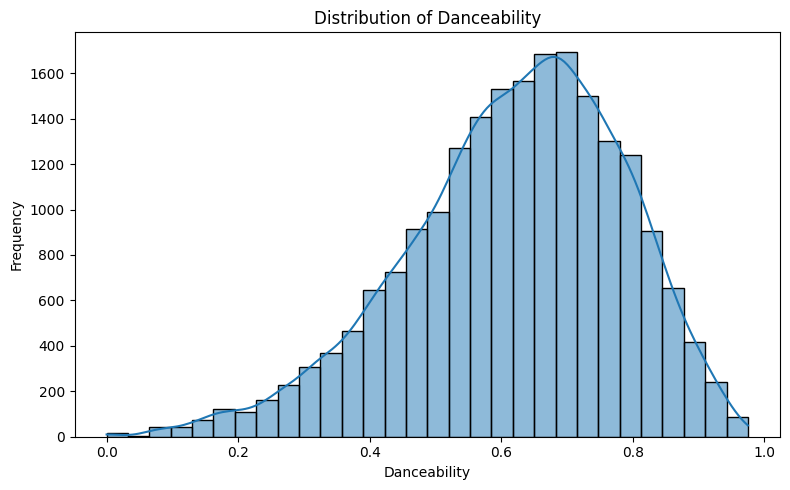

2025-04-18 07:14:21,737 - INFO - Saved histogram: ./visuals\hist_Danceability.png


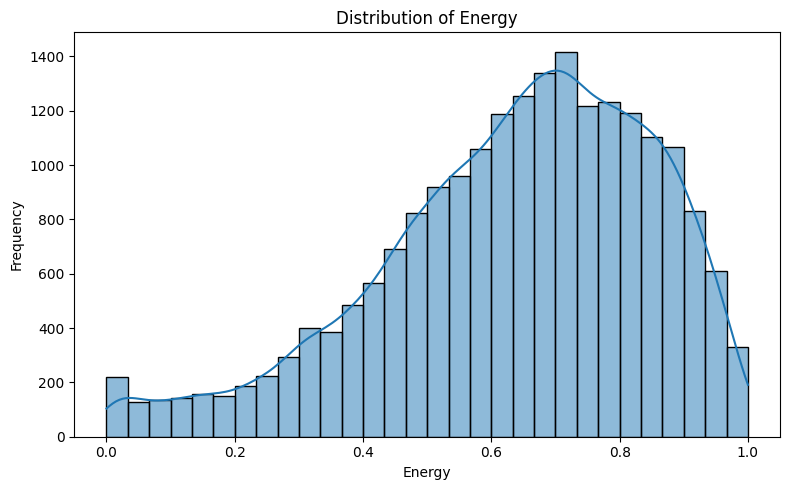

2025-04-18 07:14:22,792 - INFO - Saved histogram: ./visuals\hist_Energy.png


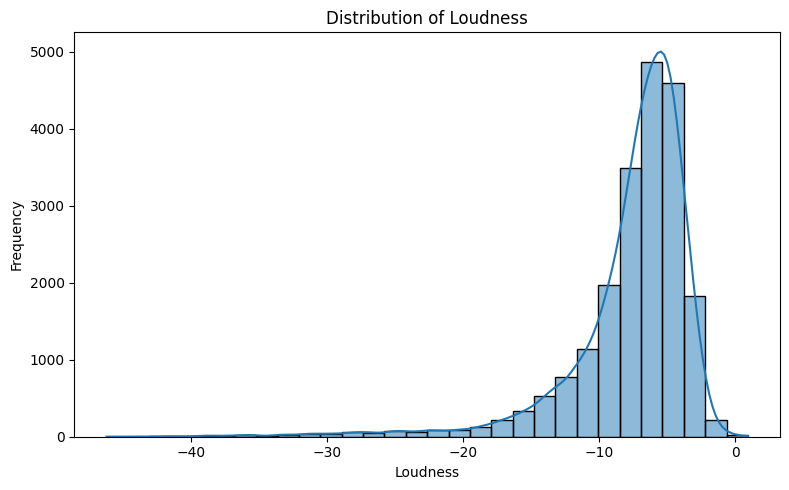

2025-04-18 07:14:23,485 - INFO - Saved histogram: ./visuals\hist_Loudness.png


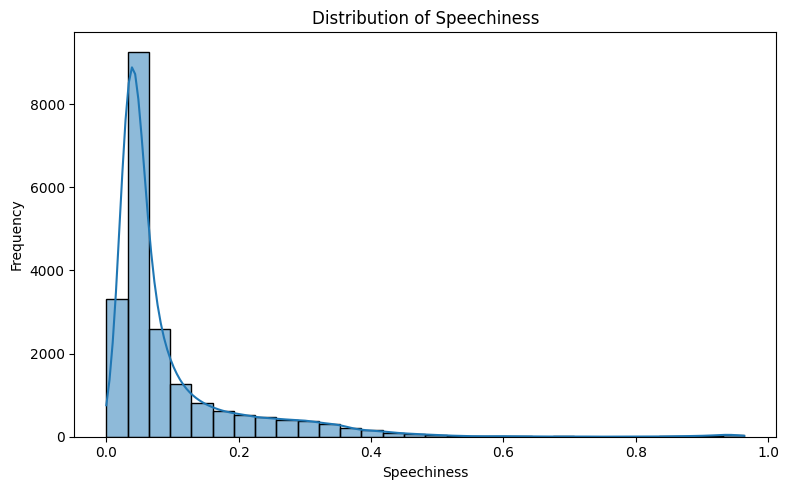

2025-04-18 07:14:24,135 - INFO - Saved histogram: ./visuals\hist_Speechiness.png


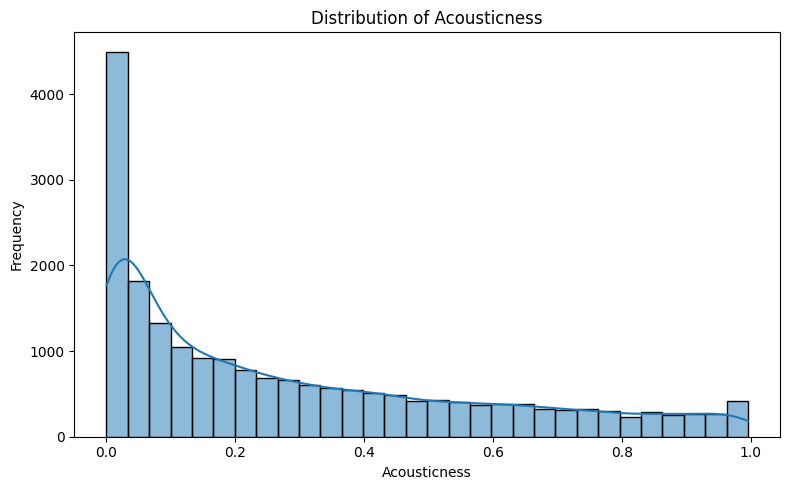

2025-04-18 07:14:24,819 - INFO - Saved histogram: ./visuals\hist_Acousticness.png


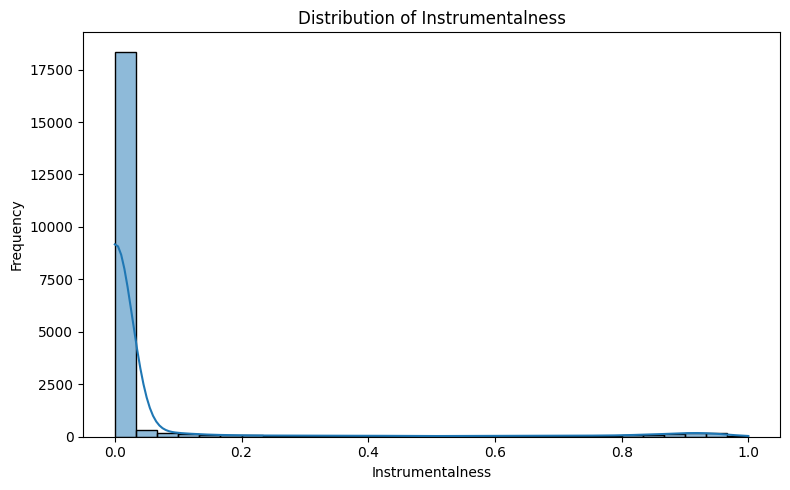

2025-04-18 07:14:25,592 - INFO - Saved histogram: ./visuals\hist_Instrumentalness.png


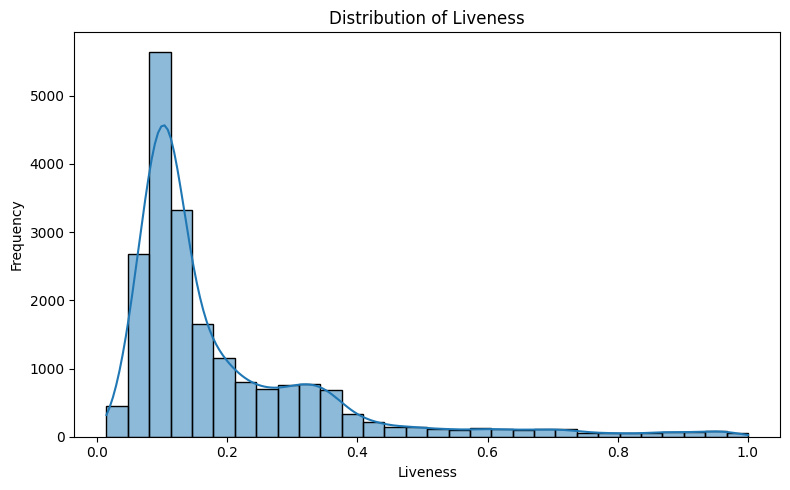

2025-04-18 07:14:26,295 - INFO - Saved histogram: ./visuals\hist_Liveness.png


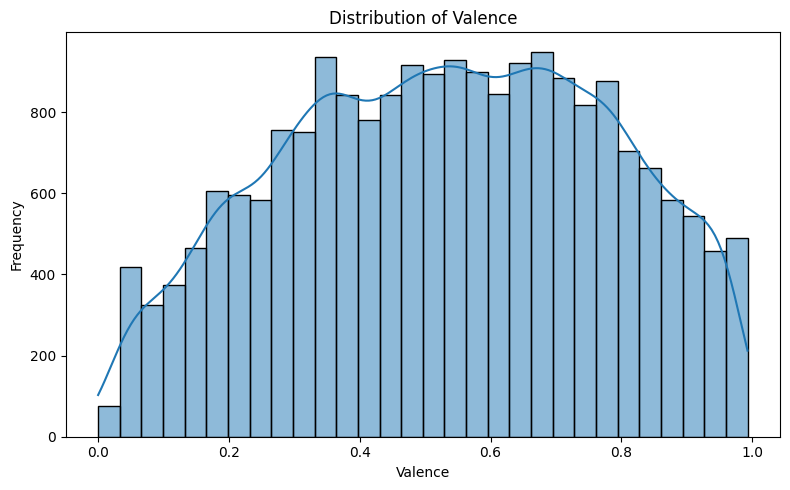

2025-04-18 07:14:27,024 - INFO - Saved histogram: ./visuals\hist_Valence.png


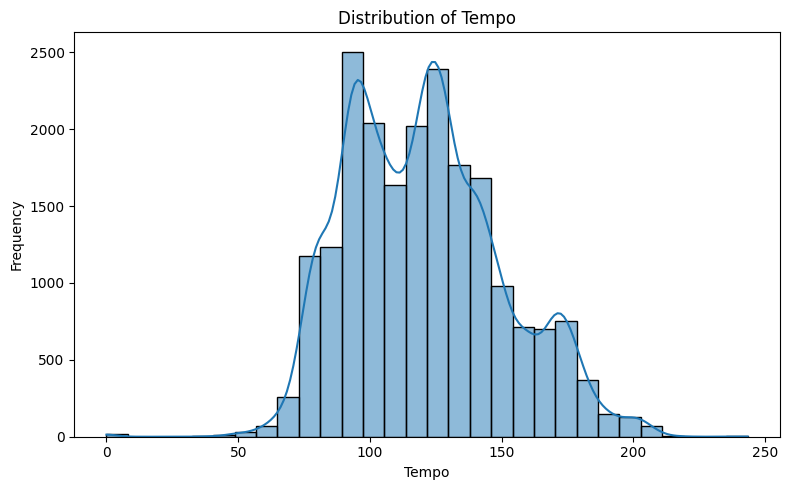

2025-04-18 07:14:27,962 - INFO - Saved histogram: ./visuals\hist_Tempo.png


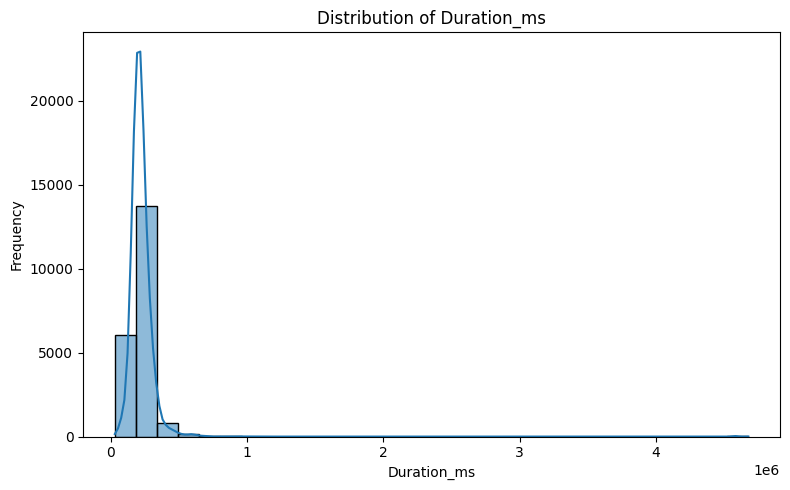

2025-04-18 07:14:28,485 - INFO - Saved histogram: ./visuals\hist_Duration_ms.png


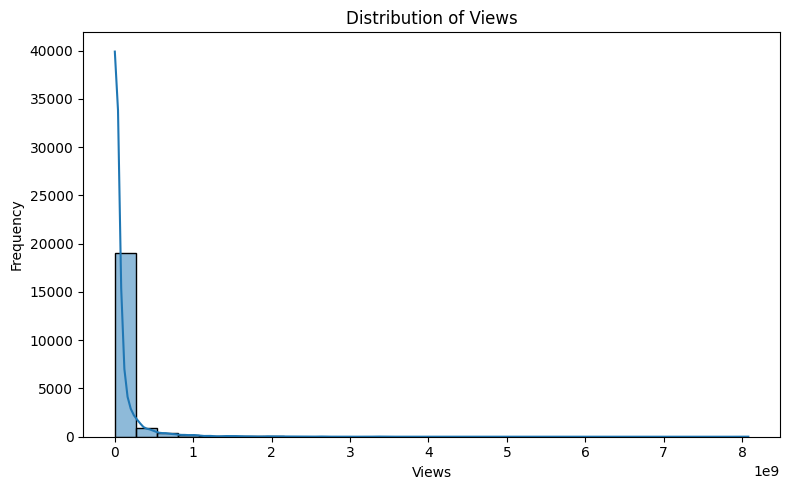

2025-04-18 07:14:29,050 - INFO - Saved histogram: ./visuals\hist_Views.png


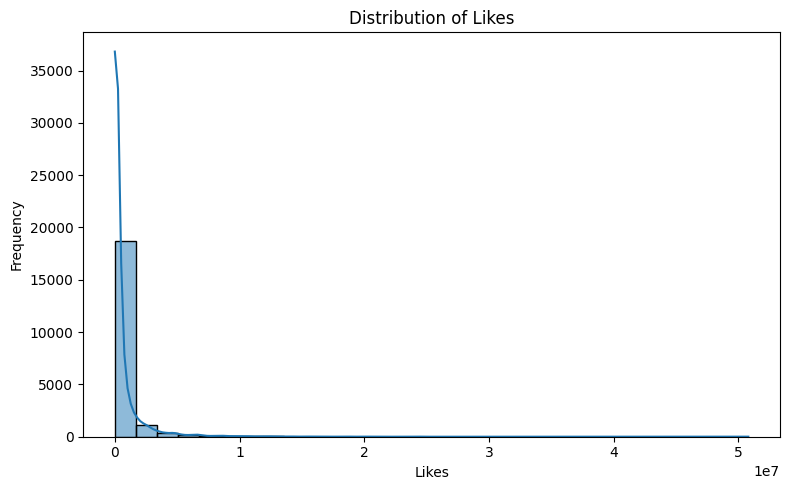

2025-04-18 07:14:29,669 - INFO - Saved histogram: ./visuals\hist_Likes.png


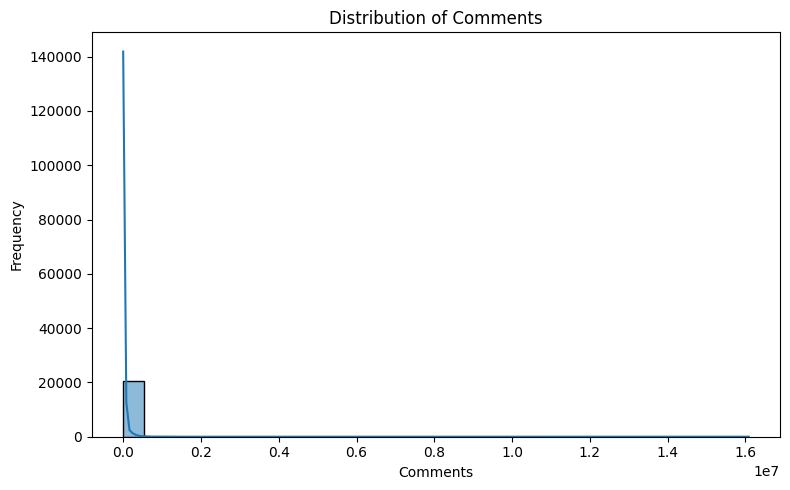

2025-04-18 07:14:30,235 - INFO - Saved histogram: ./visuals\hist_Comments.png


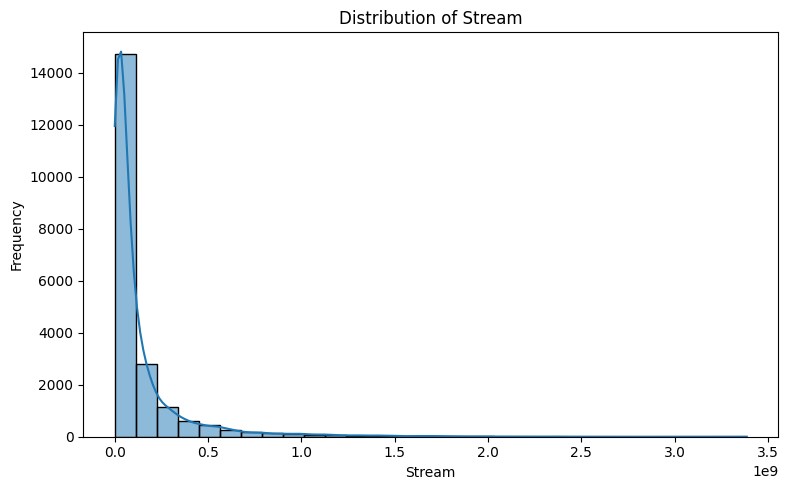

2025-04-18 07:14:30,957 - INFO - Saved histogram: ./visuals\hist_Stream.png
2025-04-18 07:14:30,957 - INFO - Finished generating histograms.


In [9]:
def histograms(df, numeric_vars, save_dir):
    """
    Generates and saves individual histograms for numeric variables.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        numeric_vars (list): List of numeric column names to plot.
        save_dir (str): Directory to save the plots.
    """
    logging.info("Generating histograms...")
    for var in numeric_vars:
        if var not in df.columns:
            logging.warning(f"Column '{var}' not found in DataFrame. Skipping histogram.")
            continue
        if not pd.api.types.is_numeric_dtype(df[var]):
             logging.warning(f"Column '{var}' is not numeric. Skipping histogram.")
             continue

        plt.figure(figsize=(8, 5))
        try:
            sns.histplot(df[var].dropna(), bins=30, kde=True)
            plt.title(f'Distribution of {var}')
            plt.xlabel(var)
            plt.ylabel('Frequency')
            plt.tight_layout()
            save_path = os.path.join(save_dir, f'hist_{var}.png')
            plt.savefig(save_path)
            plt.show()
            plt.close()
            logging.info(f"Saved histogram: {save_path}")
        except Exception as e:
            logging.error(f"Could not plot histogram for '{var}': {e}")
            plt.close()
    logging.info("Finished generating histograms.")
    

histograms(df, numeric_vars, save_dir=PLOT_DIR)

2025-04-18 07:14:30,991 - INFO - Generating box plots...


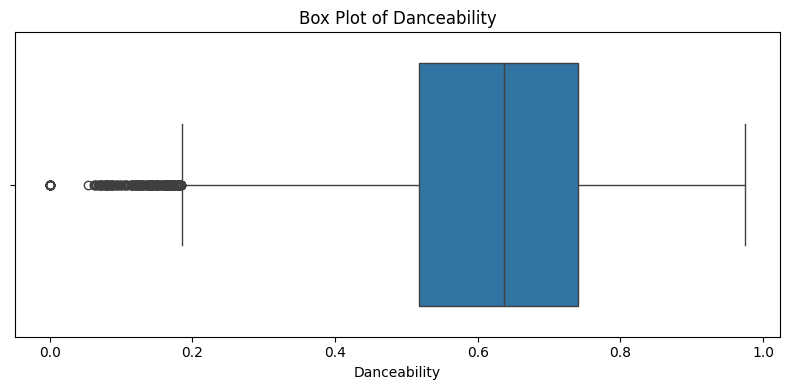

2025-04-18 07:14:31,319 - INFO - Saved box plot: ./visuals\boxplot_Danceability.png


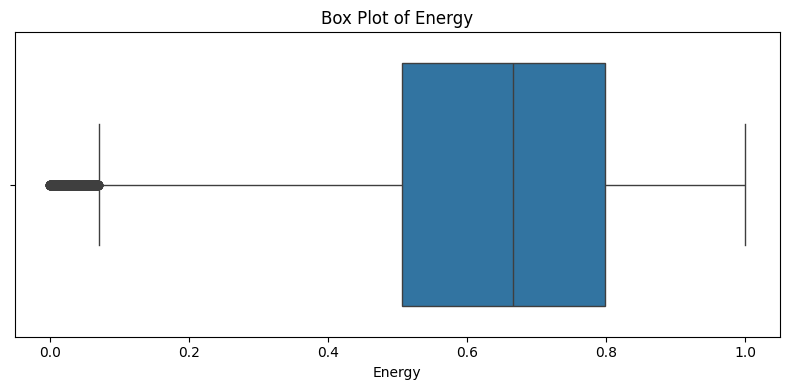

2025-04-18 07:14:31,863 - INFO - Saved box plot: ./visuals\boxplot_Energy.png


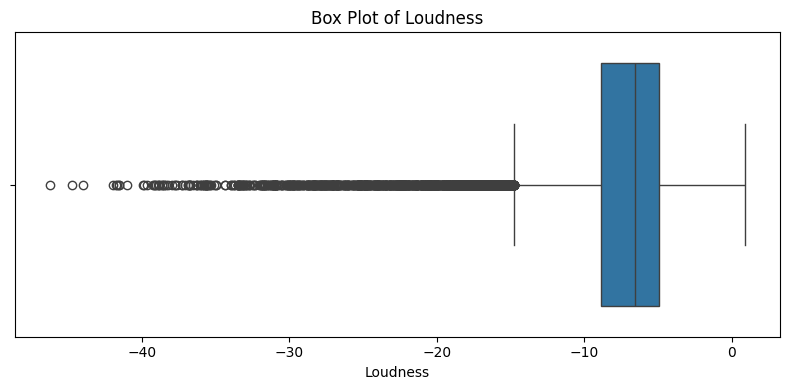

2025-04-18 07:14:32,175 - INFO - Saved box plot: ./visuals\boxplot_Loudness.png


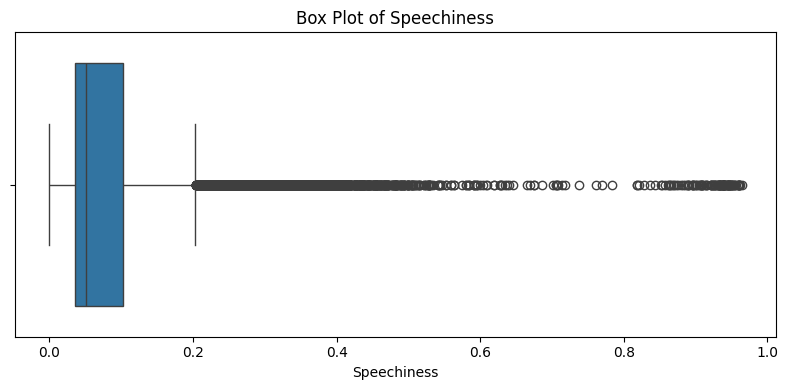

2025-04-18 07:14:32,557 - INFO - Saved box plot: ./visuals\boxplot_Speechiness.png


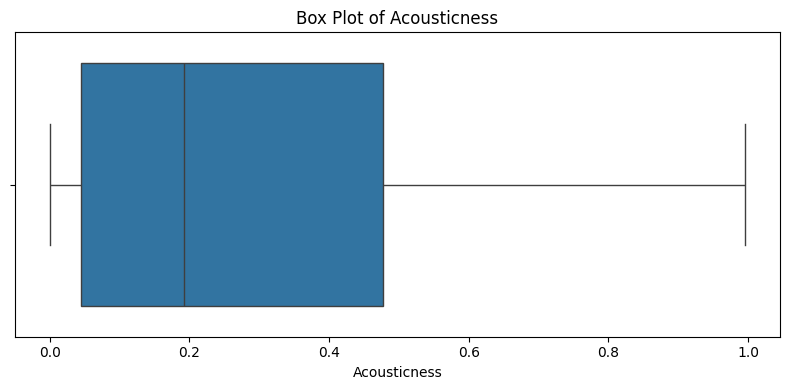

2025-04-18 07:14:32,985 - INFO - Saved box plot: ./visuals\boxplot_Acousticness.png


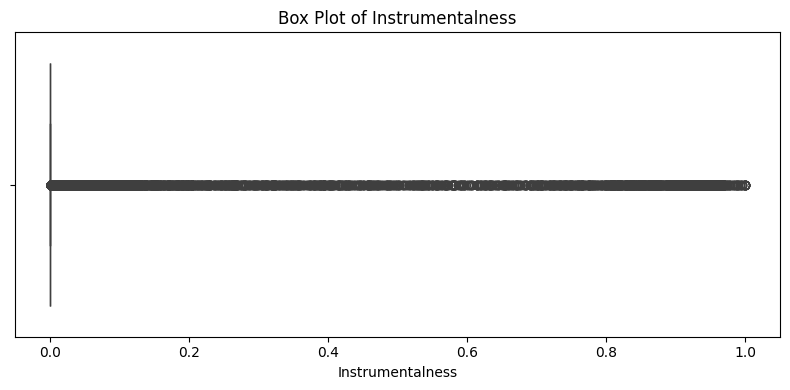

2025-04-18 07:14:33,745 - INFO - Saved box plot: ./visuals\boxplot_Instrumentalness.png


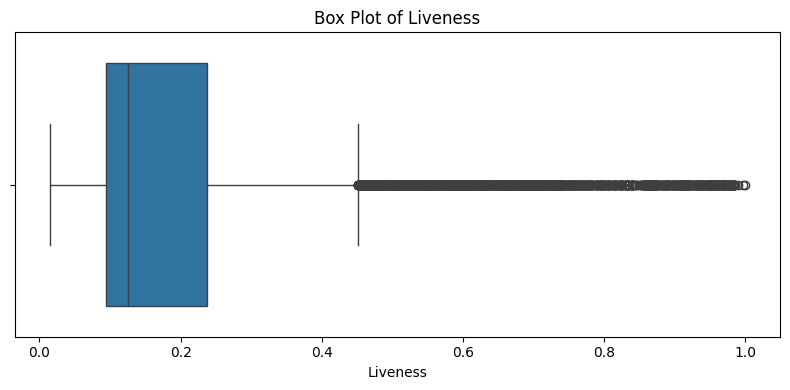

2025-04-18 07:14:34,318 - INFO - Saved box plot: ./visuals\boxplot_Liveness.png


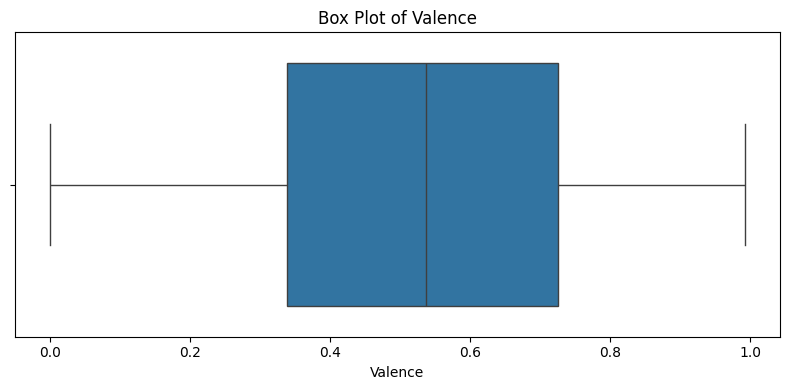

2025-04-18 07:14:34,698 - INFO - Saved box plot: ./visuals\boxplot_Valence.png


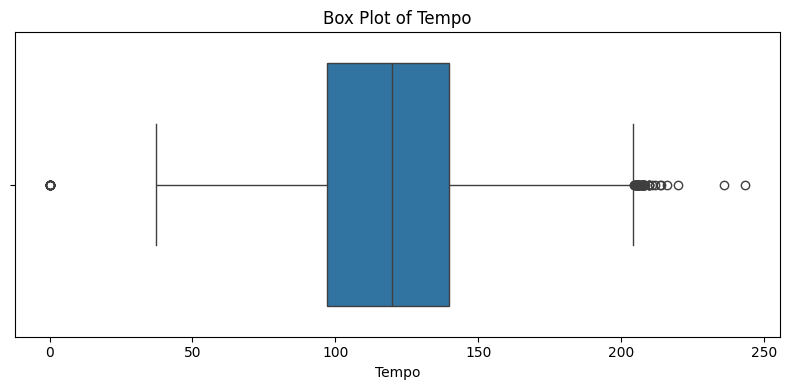

2025-04-18 07:14:35,078 - INFO - Saved box plot: ./visuals\boxplot_Tempo.png


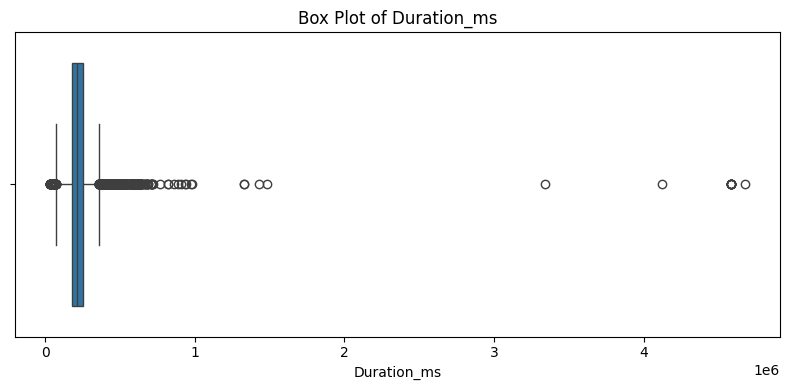

2025-04-18 07:14:35,347 - INFO - Saved box plot: ./visuals\boxplot_Duration_ms.png


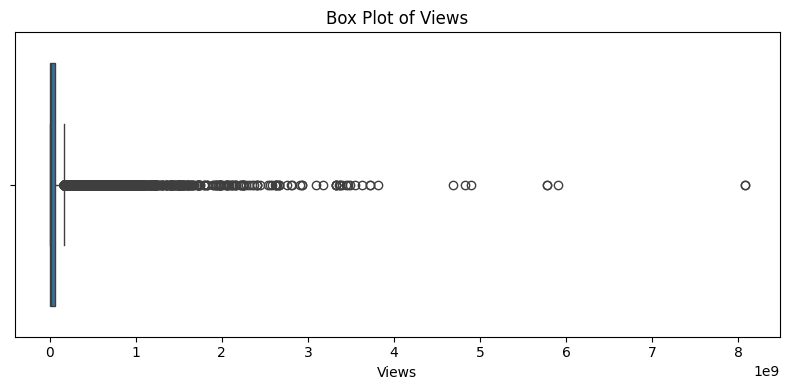

2025-04-18 07:14:35,748 - INFO - Saved box plot: ./visuals\boxplot_Views.png


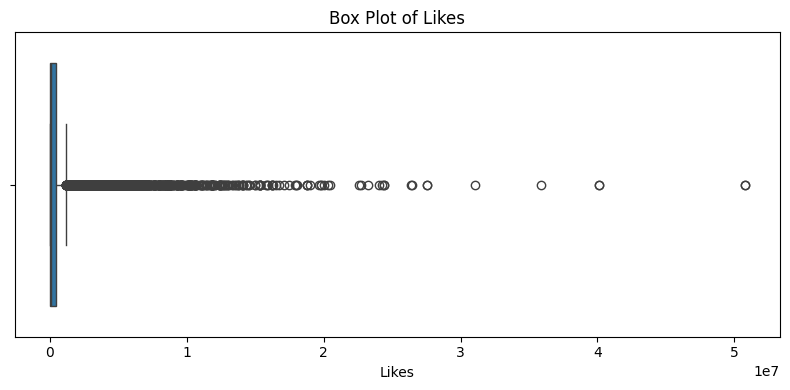

2025-04-18 07:14:36,201 - INFO - Saved box plot: ./visuals\boxplot_Likes.png


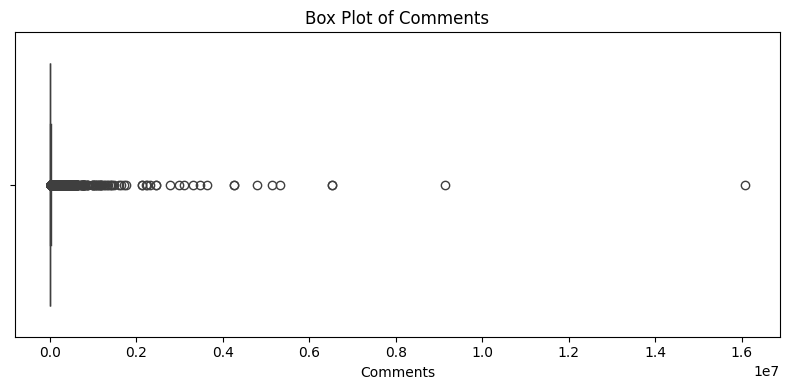

2025-04-18 07:14:37,174 - INFO - Saved box plot: ./visuals\boxplot_Comments.png


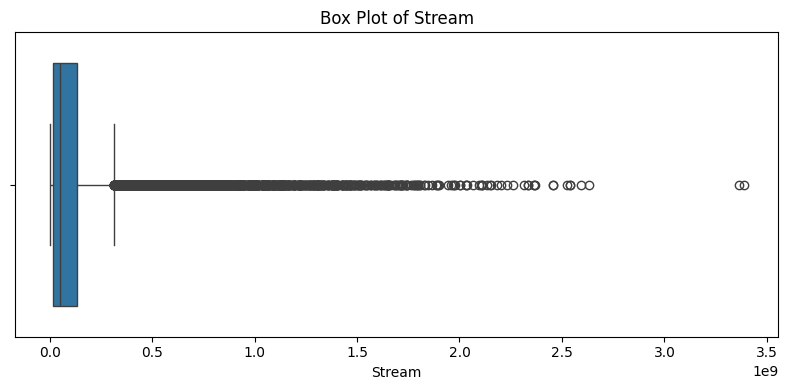

2025-04-18 07:14:38,274 - INFO - Saved box plot: ./visuals\boxplot_Stream.png
2025-04-18 07:14:38,284 - INFO - Finished generating box plots.


In [10]:
def boxplots(df, numeric_vars, save_dir):
    """
    Generates and saves individual box plots for numeric variables.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        numeric_vars (list): List of numeric column names to plot.
        save_dir (str): Directory to save the plots.
    """
    logging.info("Generating box plots...")
    for var in numeric_vars:
        if var not in df.columns:
            logging.warning(f"Column '{var}' not found in DataFrame. Skipping box plot.")
            continue
        if not pd.api.types.is_numeric_dtype(df[var]):
             logging.warning(f"Column '{var}' is not numeric. Skipping box plot.")
             continue

        plt.figure(figsize=(8, 4))
        try:
            sns.boxplot(x=df[var].dropna())
            plt.title(f'Box Plot of {var}')
            plt.tight_layout()
            save_path = os.path.join(save_dir, f'boxplot_{var}.png')
            plt.savefig(save_path)
            plt.show()
            plt.close()
            logging.info(f"Saved box plot: {save_path}")
        except Exception as e:
            logging.error(f"Could not plot box plot for '{var}': {e}")
            plt.close()
    logging.info("Finished generating box plots.")

boxplots(df, numeric_vars, save_dir=PLOT_DIR)

2025-04-18 07:29:48,692 - INFO - Saved pearson correlation matrix: ./visuals\pearson_correlation_matrix.png


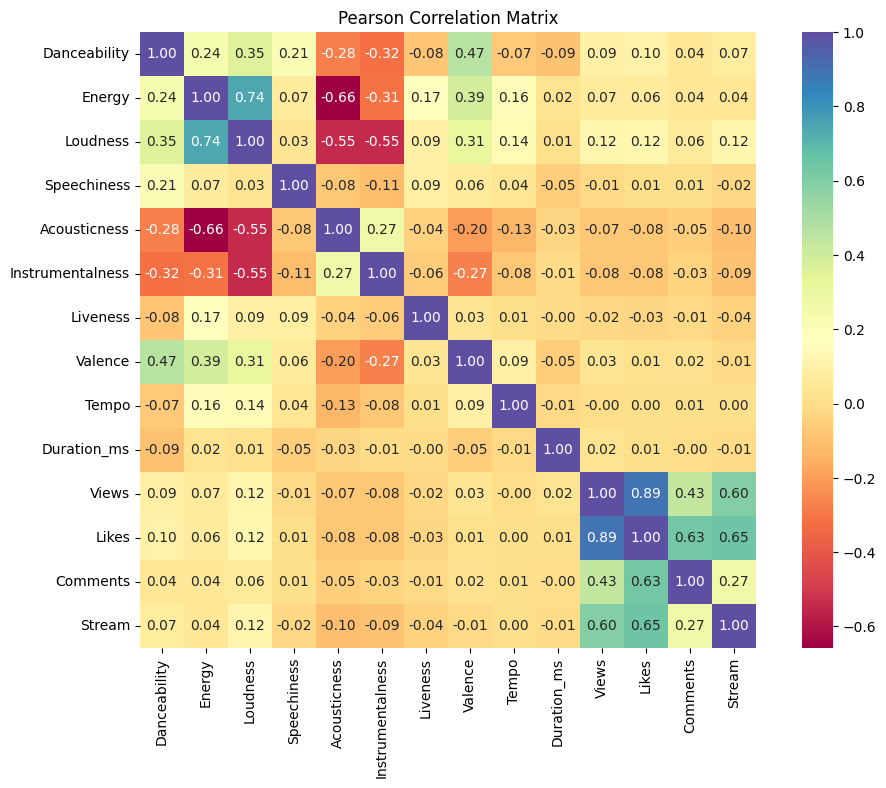

2025-04-18 07:29:49,103 - INFO - Finished generating Pearson correlation matrix.
2025-04-18 07:29:49,821 - INFO - Saved spearman correlation matrix: ./visuals\spearman_correlation_matrix.png


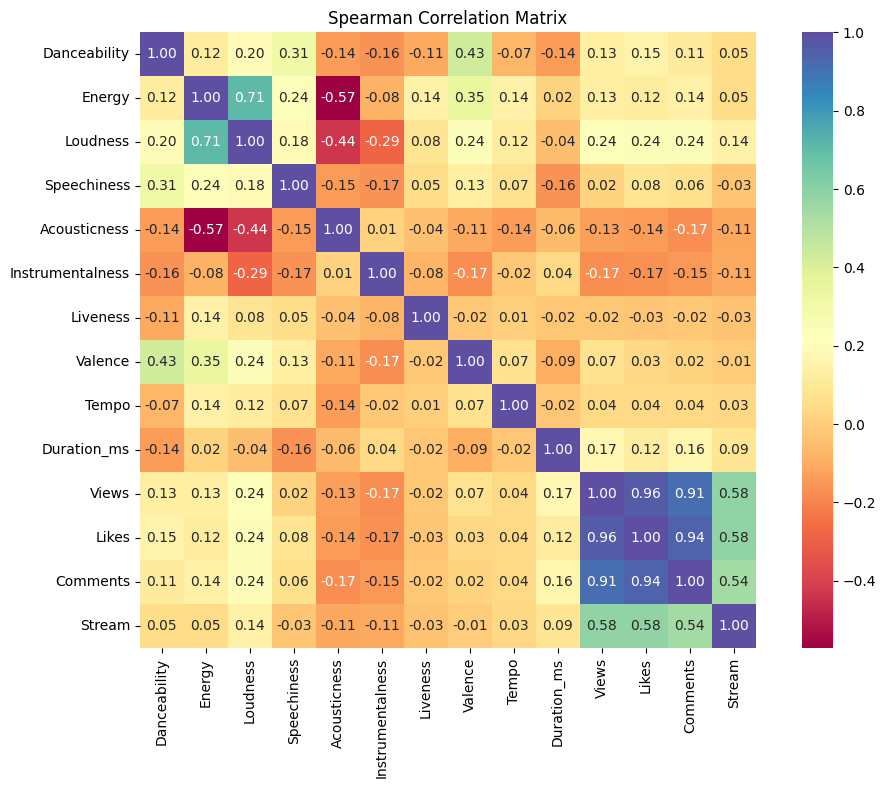

2025-04-18 07:29:50,240 - INFO - Finished generating Spearman correlation matrix.


In [15]:
def plot_correlation_matrix(df, numeric_vars, method, save_dir):
    """
    Calculates and visualizes the correlation matrix for numeric variables using the specified method.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        numeric_vars (list): List of numeric column names to include in the correlation matrix.
        method (str, optional): Correlation method ('pearson' or 'spearman'). Defaults to 'pearson'.
        save_dir (str, optional): File path to save the plot. If None, the plot is not saved. Defaults to None.
    """
    try:
        correlation_matrix = df[numeric_vars].corr(method=method)

        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='Spectral', square=True)
        plt.title(f'{method.capitalize()} Correlation Matrix')

        if save_dir:
            save_path = os.path.join(save_dir, f'{method}_correlation_matrix.png')
            plt.savefig(save_path)
            logging.info(f"Saved {method} correlation matrix: {save_path}")
        plt.show()
        plt.close()

    except Exception as e:
        logging.error(f"Could not plot {method} correlation matrix: {e}")
        plt.close()

    logging.info(f"Finished generating {method.capitalize()} correlation matrix.")

plot_correlation_matrix(df, numeric_vars, method="pearson", save_dir=PLOT_DIR)
plot_correlation_matrix(df, numeric_vars, method="spearman", save_dir=PLOT_DIR)

Saved to: ./visuals\scatter_duration_views.png


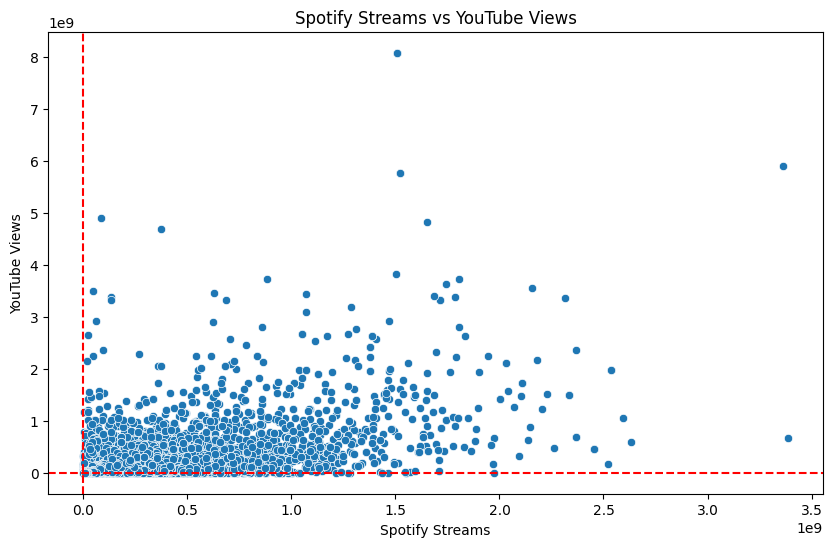

Correlation between Spotify Streams and YouTube Views: 0.5970291579006117


In [16]:
def analyze_stream_view_correlation(df, save_dir):
    """
    Calculates and visualizes the correlation between Spotify Streams and YouTube Views.

    Args:
        df (pd.DataFrame): DataFrame containing song data with 'Stream' and 'Views' columns.
    """
    try:
        correlation_streams_views = df['Stream'].corr(df['Views'])
    except KeyError as e:
        print(f"Error: One or both of the columns ('Stream', 'Views') are missing: {e}")
        return
    except Exception as e:
        print(f"An unexpected error occurred during correlation calculation: {e}")
        return

    plt.figure(figsize=(10, 6))
    try:
        sns.scatterplot(data=df, x='Stream', y='Views')
    except Exception as e:
        print(f"Error creating scatter plot: {e}")
        return
    plt.title('Spotify Streams vs YouTube Views')
    plt.xlabel('Spotify Streams')
    plt.ylabel('YouTube Views')
    plt.axhline(0, color='red', linestyle='--')
    plt.axvline(0, color='red', linestyle='--')

    if save_dir:
        save_path = os.path.join(save_dir, 'scatter_duration_views.png')
        plt.savefig(save_path)
        print(f"Saved to: {save_path}")
    plt.show()
    plt.close()
    
    print('Correlation between Spotify Streams and YouTube Views:', correlation_streams_views)

analyze_stream_view_correlation(df, save_dir=PLOT_DIR)

In [17]:
def analyze_platform_success(df):
    """
    Analyzes the success rate of songs on YouTube vs Spotify based on views and streams.

    Args:
        df (pd.DataFrame): The DataFrame containing song data with 'Views' and 'Stream' columns.

    Returns:
        pd.DataFrame: A DataFrame containing success metrics grouped by platform dominance.
    """
    df['youtube_spotify_ratio'] = df['Views'] / df['Stream']
    df['success_category'] = np.where(df['youtube_spotify_ratio'] > 1, 'YouTube Dominant', 'Spotify Dominant')

    success_metrics = df.groupby('success_category').agg({
        'Views': 'mean',
        'Stream': 'mean',
        'Danceability': 'mean',
        'Energy': 'mean',
        'Acousticness': 'mean'
    }).round(2)

    return success_metrics

analyze_platform_success(df)

,Views,Stream,Danceability,Energy,Acousticness
success_category,,,,,
Spotify Dominant,4.473533e+07,1.366571e+08,0.61,0.63,0.29
YouTube Dominant,2.625170e+08,1.239099e+08,0.65,0.67,0.29


Saved to: ./visuals\scatter_duration_vs_views.png


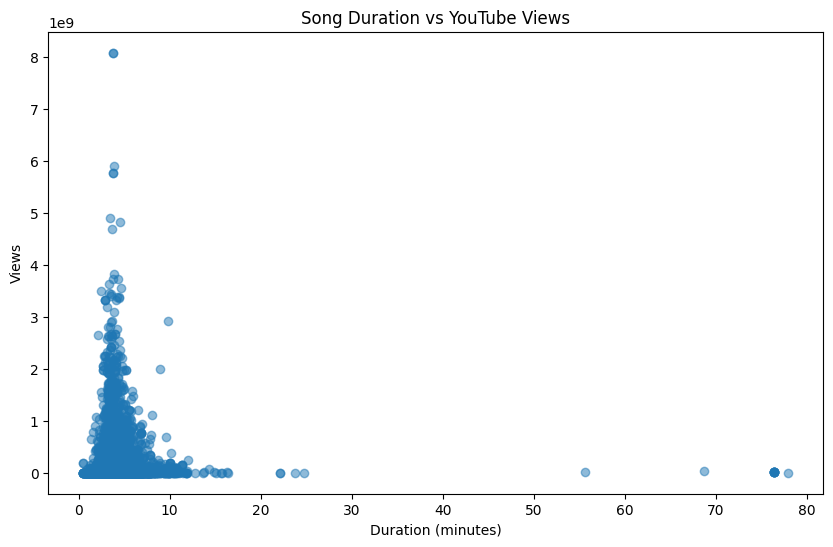


Correlation between Duration and Views: 0.022


In [18]:
def analyze_song_duration(df, save_dir):
    """
    Analyzes the relationship between song duration and YouTube views.

    Args:
        df (pd.DataFrame): The DataFrame containing song data with 'Duration_ms' and 'Views' columns.
        save_dir (str): Directory to save the plots.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Duration_ms']/60000, df['Views'], alpha=0.5)
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Views')
    plt.title('Song Duration vs YouTube Views')

    if save_dir:
        save_path = os.path.join(save_dir, 'scatter_duration_vs_views.png')
        plt.savefig(save_path)
        print(f"Saved to: {save_path}")
    plt.show()
    plt.close()

    duration_corr = df['Duration_ms'].corr(df['Views'])
    print(f"\nCorrelation between Duration and Views: {duration_corr:.3f}")

analyze_song_duration(df, save_dir=PLOT_DIR)

Saved to: ./visuals\Title Word Count.png


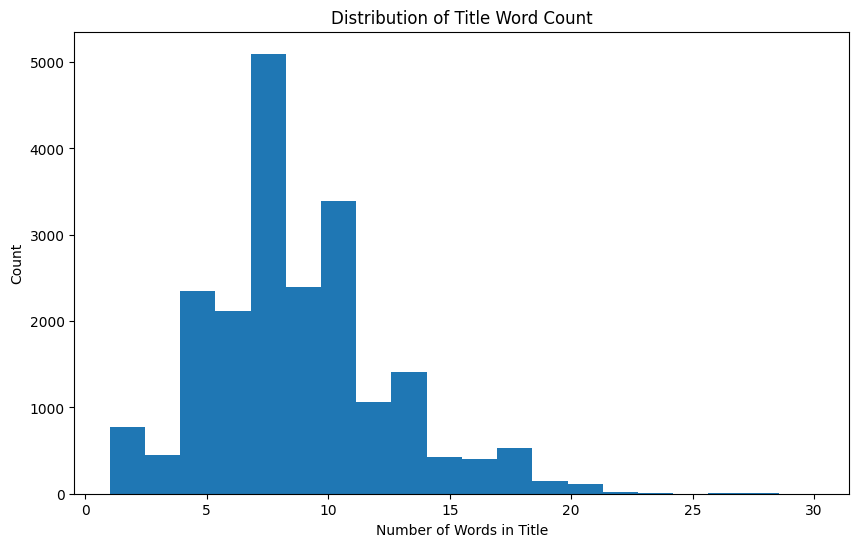


Average Views by Title Length:
title_length_cat
Very Short    5.322875e+07
Short         9.273336e+07
Medium        9.879426e+07
Long          1.033660e+08
Very Long     1.142818e+08
Name: Views, dtype: float64


C:\Users\alleksenes\AppData\Local\Temp\ipykernel_6720\4001572491.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  title_length_analysis = df.groupby('title_length_cat')['Views'].mean().round(2)


In [19]:
def analyze_title_length(df, save_dir):
    """
    Analyzes the impact of title length on YouTube views.

    Args:
        df (pd.DataFrame): The DataFrame containing song data with a 'Title' column.
        save_dir (str): Directory to save the plots.
    """
    df['title_length'] = df['Title'].str.len()
    df['title_word_count'] = df['Title'].str.split().str.len()

    plt.figure(figsize=(10, 6))
    plt.hist(df['title_word_count'], bins=20)
    plt.xlabel('Number of Words in Title')
    plt.ylabel('Count')
    plt.title('Distribution of Title Word Count')
    if save_dir:
        save_path = os.path.join(save_dir, 'Title Word Count.png')
        plt.savefig(save_path)
        print(f"Saved to: {save_path}")
    plt.show()
    plt.close()

    df['title_length_cat'] = pd.qcut(df['title_length'], q=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
    title_length_analysis = df.groupby('title_length_cat')['Views'].mean().round(2)

    print("\nAverage Views by Title Length:")
    print(title_length_analysis)

analyze_title_length(df, save_dir=PLOT_DIR)

In [20]:
def generate_profile_report(df, output_file="profile_report.html"):
    """
    Generates a Pandas Profiling report and saves it to an HTML file.

    Args:
        df (pd.DataFrame): The DataFrame to profile.
        output_file (str): The name of the HTML file to save the report to.  Defaults to "profile_report.html".
    """
    if not isinstance(df, pd.DataFrame):
        print("Error: Input 'df' must be a pandas DataFrame.")
        return

    try:
        profile_report = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
        profile_report.to_file(output_file)
        print(f"Profile report generated successfully and saved to '{output_file}'")
    except NameError:
        print("Error: ProfileReport is not defined.  Make sure you have ydata_profiling installed and imported.")
    except Exception as e:
        print(f"An error occurred during profile report generation: {e}")

generate_profile_report(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\alleksenes\.pyenv\pyenv-win\versions\3.12.8\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'Function <code object pandas_auto_compute at 0x000002894A1AEE00, file "c:\Users\alleksenes\.pyenv\pyenv-win\versions\3.12.8\Lib\site-packages\ydata_profiling\model\pandas\correlations_pandas.py", line 167>')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile report generated successfully and saved to 'profile_report.html'


## CATEGORICAL EDA

In [21]:
categorical_vars = ['Album_type', 'Licensed', 'official_video']

categorical_frequencies = {}
for var in categorical_vars:
    try:
        categorical_frequencies[var] = df[var].value_counts()
    except KeyError:
        print(f"Error: Column '{var}' not found in DataFrame. Skipping.")
        continue


Saved to: ./visuals\categorical_frequencies.png


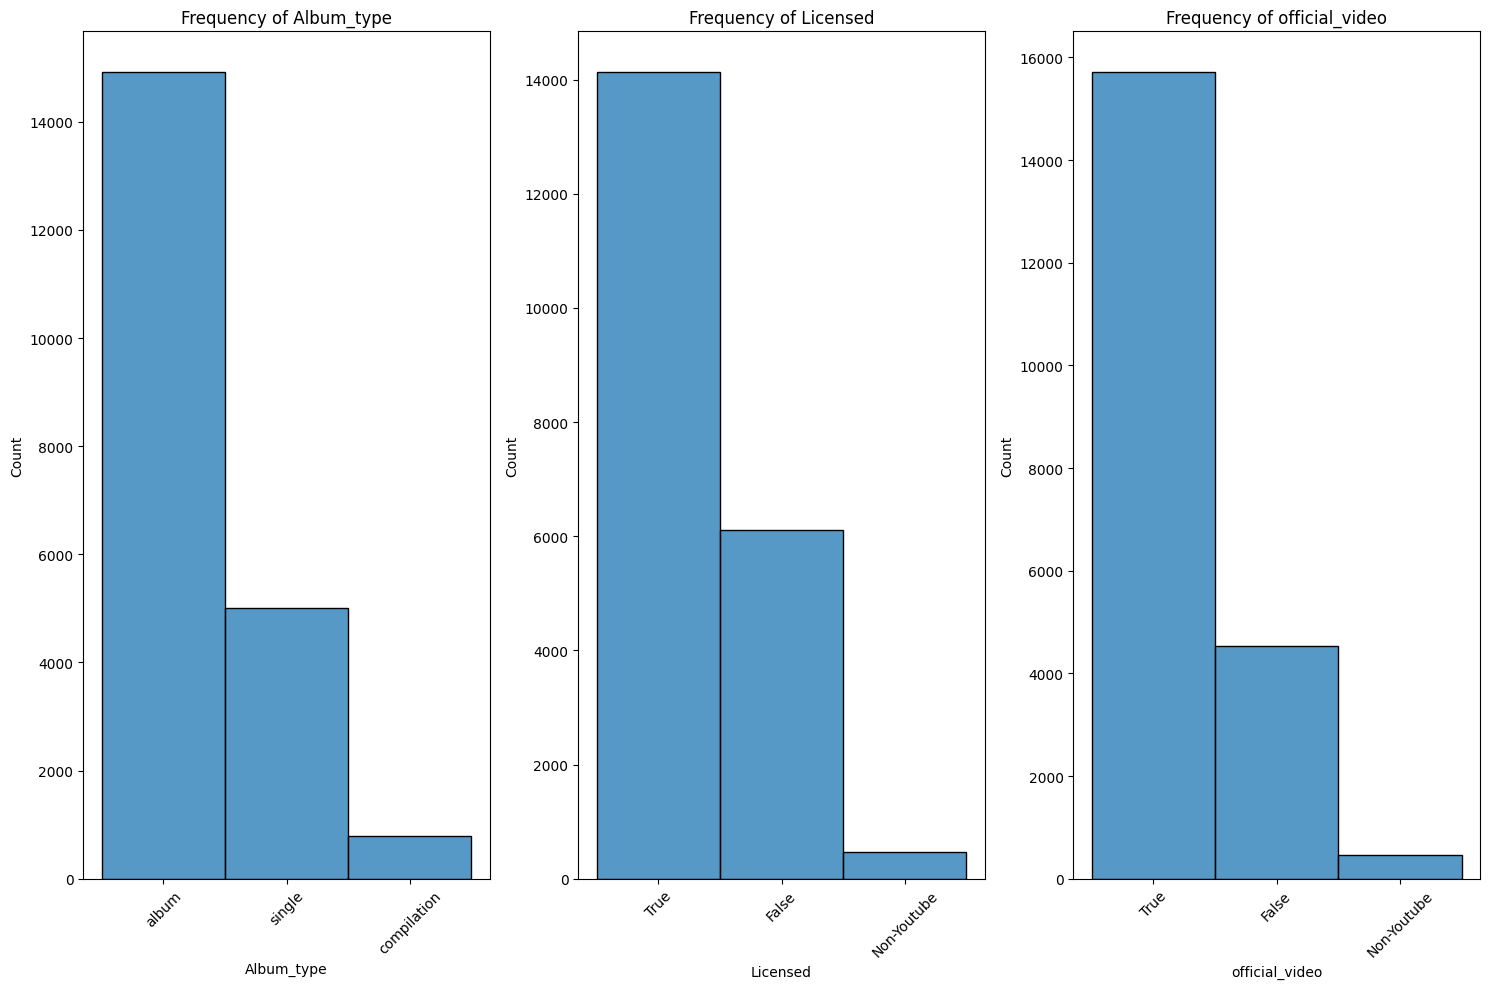

Frequency of Album_type:
Album_type
album          14926
single          5004
compilation      788
Name: count, dtype: int64


Frequency of Licensed:
Licensed
True           14140
False           6108
Non-Youtube      470
Name: count, dtype: int64


Frequency of official_video:
official_video
True           15723
False           4525
Non-Youtube      470
Name: count, dtype: int64




In [22]:
def analyze_categorical_variables(df, categorical_vars, save_dir):
    """
    Analyzes the frequency of categorical variables in a DataFrame and visualizes them using histograms.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        categorical_vars (list): A list of column names representing categorical variables.
        save_dir (str, optional): Directory to save the plot. If None, the plot is not saved. Defaults to None.
    """

    plt.figure(figsize=(15, 10))
    for i, var in enumerate(categorical_vars, 1):
        if var not in categorical_frequencies:
            continue
        plt.subplot(1, 3, i)
        try:
            sns.histplot(data=df, x=var)
        except Exception as e:
            print(f"Warning: Could not plot countplot for '{var}': {e}")
            continue
        plt.title(f'Frequency of {var}')
        plt.xticks(rotation=45)

    plt.tight_layout()

    if save_dir:
        save_path = os.path.join(save_dir, 'categorical_frequencies.png')
        plt.savefig(save_path)
        print(f"Saved to: {save_path}")

    plt.show()
    plt.close()

    for var, freq in categorical_frequencies.items():
        print(f'Frequency of {var}:')
        print(freq)
        print('\n')

analyze_categorical_variables(df, categorical_vars, save_dir=PLOT_DIR)

Saved to: ./visuals\album_type_distribution.png


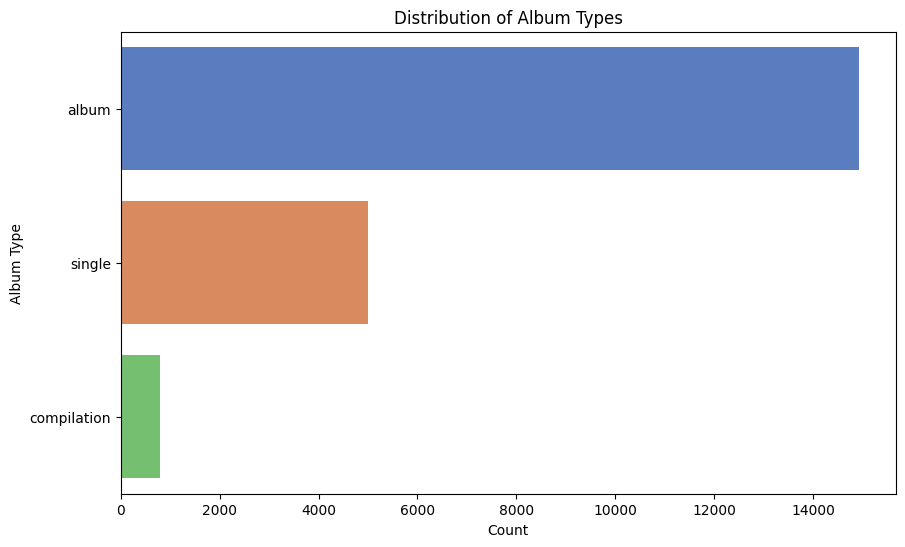

In [23]:
def analyze_album_type_distribution(df, save_dir):
    """
    Analyzes and visualizes the distribution of album types.

    Args:
        df (pd.DataFrame): The DataFrame containing song data with an 'Album_type' column.
        save_dir (str, optional): Directory to save the plot. If None, the plot is not saved. Defaults to None.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(y='Album_type', data=df, order=df['Album_type'].value_counts().index, hue='Album_type', palette='muted', dodge=False, legend=False)
    plt.title('Distribution of Album Types')
    plt.xlabel('Count')
    plt.ylabel('Album Type')

    if save_dir:
        save_path = os.path.join(save_dir, 'album_type_distribution.png')
        plt.savefig(save_path)
        print(f"Saved to: {save_path}")

    plt.show()
    plt.close()

analyze_album_type_distribution(df, save_dir=PLOT_DIR)

Saved to: ./visuals\top_10_spotify_songs.png


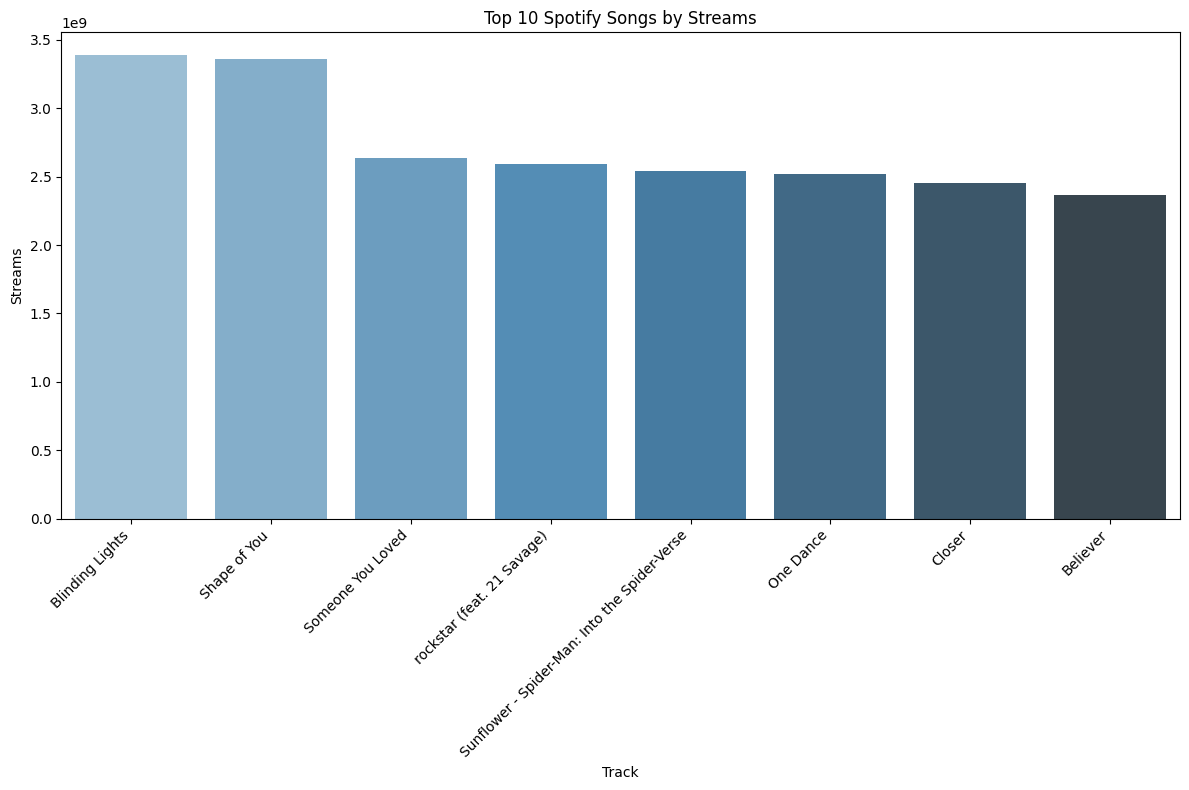

Saved to: ./visuals\top_10_youtube_songs.png


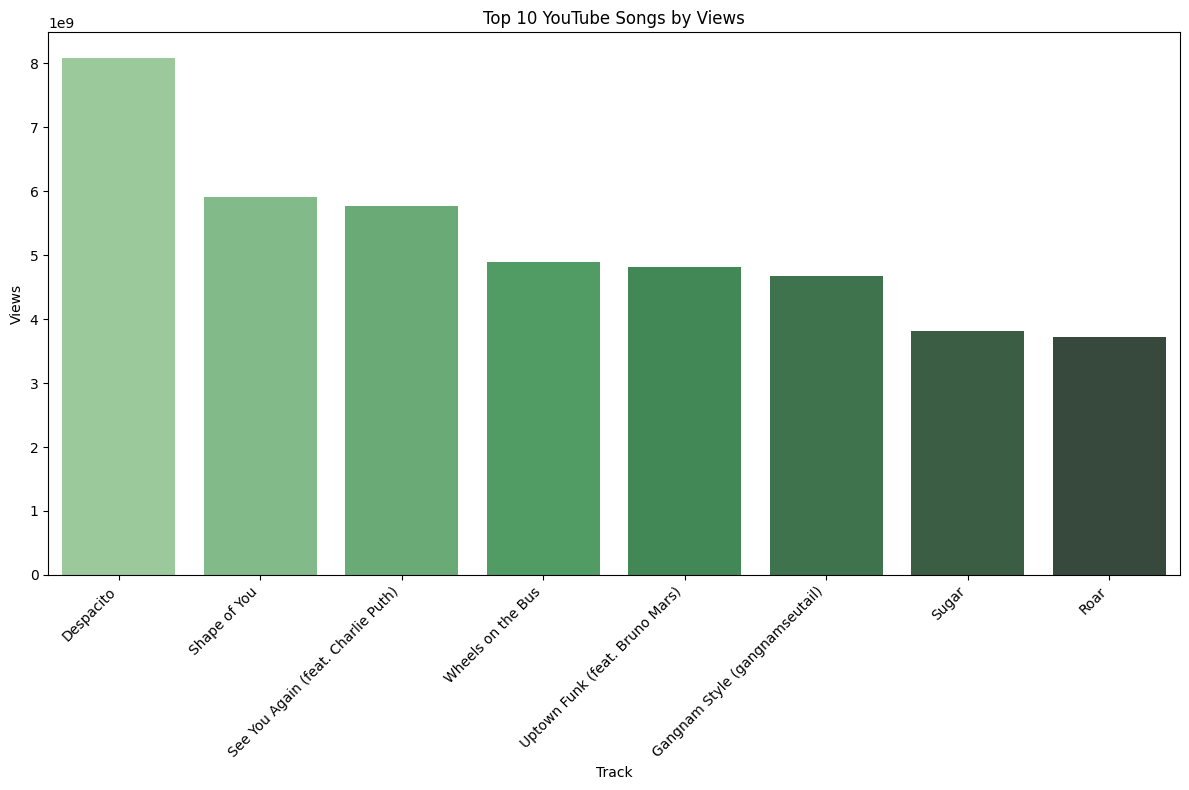

In [24]:
def analyze_top_songs(df, save_dir):
    """
    Analyzes and visualizes the top 10 songs on Spotify and YouTube based on streams and views, respectively.

    Args:
        df (pd.DataFrame): The DataFrame containing song data with 'Track', 'Artist', 'Stream', and 'Views' columns.
        save_dir (str, optional): Directory to save the plot. If None, the plot is not saved. Defaults to None.
    """

    spotify_top_10 = df.nlargest(10, 'Stream')[['Track', 'Artist', 'Stream']]
    spotify_tracks = spotify_top_10['Track'].tolist()
    spotify_artists = spotify_top_10['Artist'].tolist()
    spotify_streams = spotify_top_10['Stream'].tolist()

    youtube_top_10 = df.nlargest(10, 'Views')[['Track', 'Artist', 'Views']]
    youtube_tracks = youtube_top_10['Track'].tolist()
    youtube_artists = youtube_top_10['Artist'].tolist()
    youtube_views = youtube_top_10['Views'].tolist()

    max_len = max(len(spotify_tracks), len(youtube_tracks))
    spotify_tracks += [''] * (max_len - len(spotify_tracks))
    spotify_artists += [''] * (max_len - len(spotify_artists))
    spotify_streams += [0] * (max_len - len(spotify_streams))
    youtube_tracks += [''] * (max_len - len(youtube_tracks))
    youtube_artists += [''] * (max_len - len(youtube_artists))
    youtube_views += [0] * (max_len - len(youtube_views))

    top_songs = pd.DataFrame({
        'Spotify_Track': spotify_tracks,
        'Spotify_Artist': spotify_artists,
        'Spotify_Stream': spotify_streams,
        'YouTube_Track': youtube_tracks,
        'YouTube_Artist': youtube_artists,
        'YouTube_Views': youtube_views
    })

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Spotify_Track', y='Spotify_Stream', data=top_songs, hue='Spotify_Track', palette="Blues_d", legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Spotify Songs by Streams')
    plt.xlabel('Track')
    plt.ylabel('Streams')
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, 'top_10_spotify_songs.png')
        plt.savefig(save_path)
        print(f"Saved to: {save_path}")

    plt.show()
    plt.close()

    plt.figure(figsize=(12, 8))
    sns.barplot(x='YouTube_Track', y='YouTube_Views', data=top_songs, hue='YouTube_Track', palette="Greens_d", legend = False)
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 YouTube Songs by Views')
    plt.xlabel('Track')
    plt.ylabel('Views')
    plt.tight_layout()

    if save_dir:
        save_path = os.path.join(save_dir, 'top_10_youtube_songs.png')
        plt.savefig(save_path)
        print(f"Saved to: {save_path}")

    plt.show()
    plt.close()

analyze_top_songs(df, save_dir=PLOT_DIR)

Saved to: ./visuals\top_10_channels.png


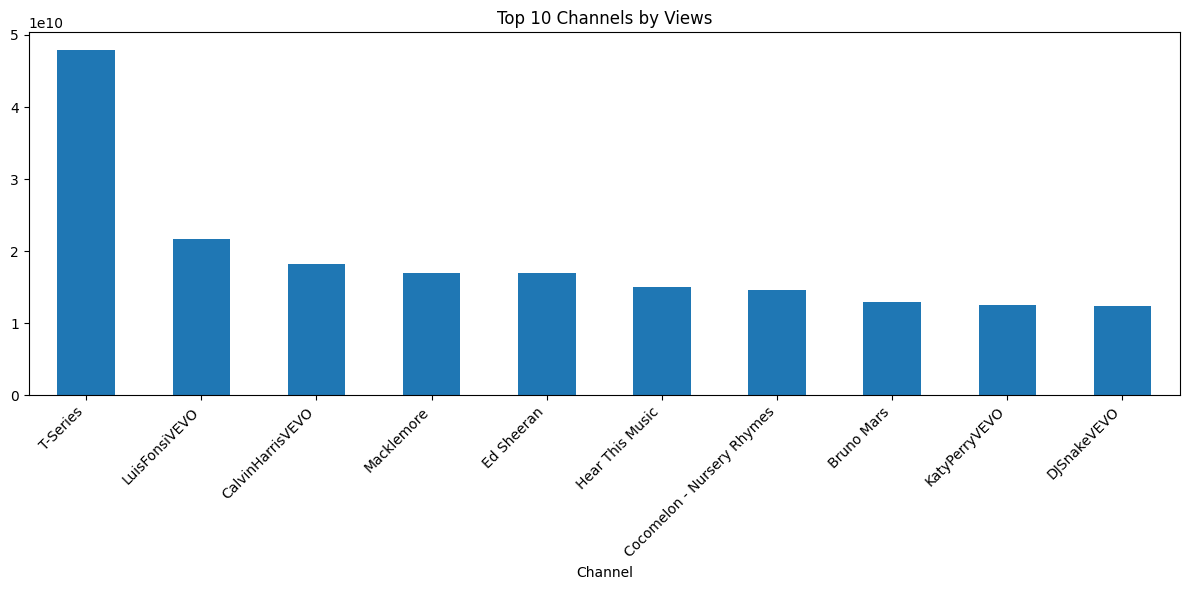

In [25]:
def analyze_top_channels(df, save_dir):
    """
    Analyzes and visualizes the top 10 channels by total views.

    Args:
        df (pd.DataFrame): The DataFrame containing song data with 'Channel', 'Views', 'Likes', and 'Comments' columns.
        save_dir (str, optional): Directory to save the plot. If None, the plot is not saved. Defaults to None.
    """
    channel_stats = df.groupby('Channel').agg({
        'Views': 'sum',
        'Likes': 'sum',
        'Comments': 'sum'
    }).sort_values('Views', ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    channel_stats['Views'].plot(kind='bar')
    plt.title('Top 10 Channels by Views')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    if save_dir:
        save_path = os.path.join(save_dir, 'top_10_channels.png')
        plt.savefig(save_path)
        print(f"Saved to: {save_path}")

    plt.show()
    plt.close()

analyze_top_channels(df, save_dir=PLOT_DIR)

Saved to: ./visuals\licensed_content_distribution.png


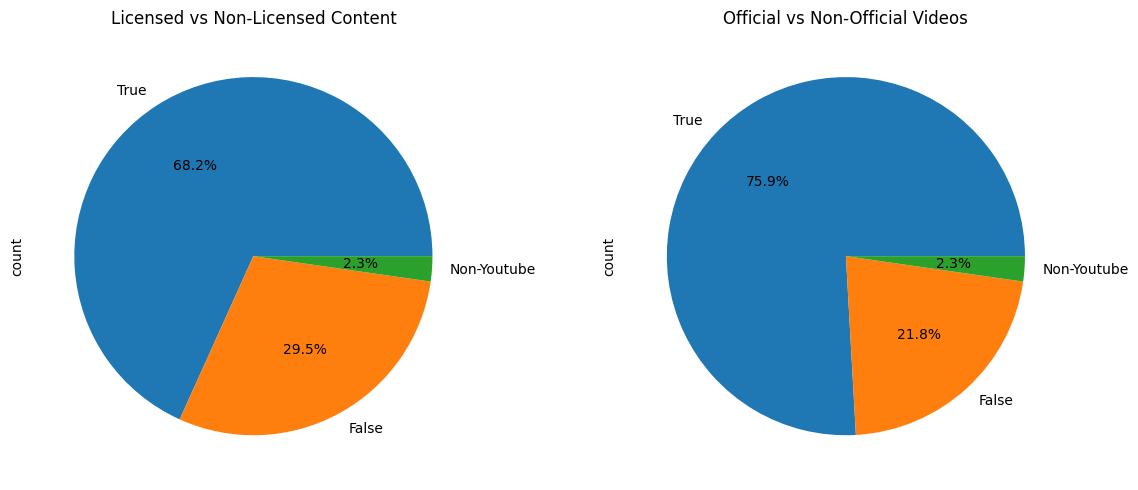

In [26]:
def analyze_licensed_content(df, save_dir):
    """
    Analyzes and visualizes the distribution of licensed vs non-licensed content and official vs non-official videos.

    Args:
        df (pd.DataFrame): The DataFrame containing song data with 'Licensed' and 'official_video' columns.
         save_dir (str, optional): Directory to save the plot. If None, the plot is not saved. Defaults to None.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    df['Licensed'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Licensed vs Non-Licensed Content')

    plt.subplot(1, 2, 2)
    df['official_video'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Official vs Non-Official Videos')

    plt.tight_layout()

    if save_dir:
        save_path = os.path.join(save_dir, 'licensed_content_distribution.png')
        plt.savefig(save_path)
        print(f"Saved to: {save_path}")

    plt.show()
    plt.close()

analyze_licensed_content(df, save_dir=PLOT_DIR)

Saved to: ./visuals\wordclouds.png


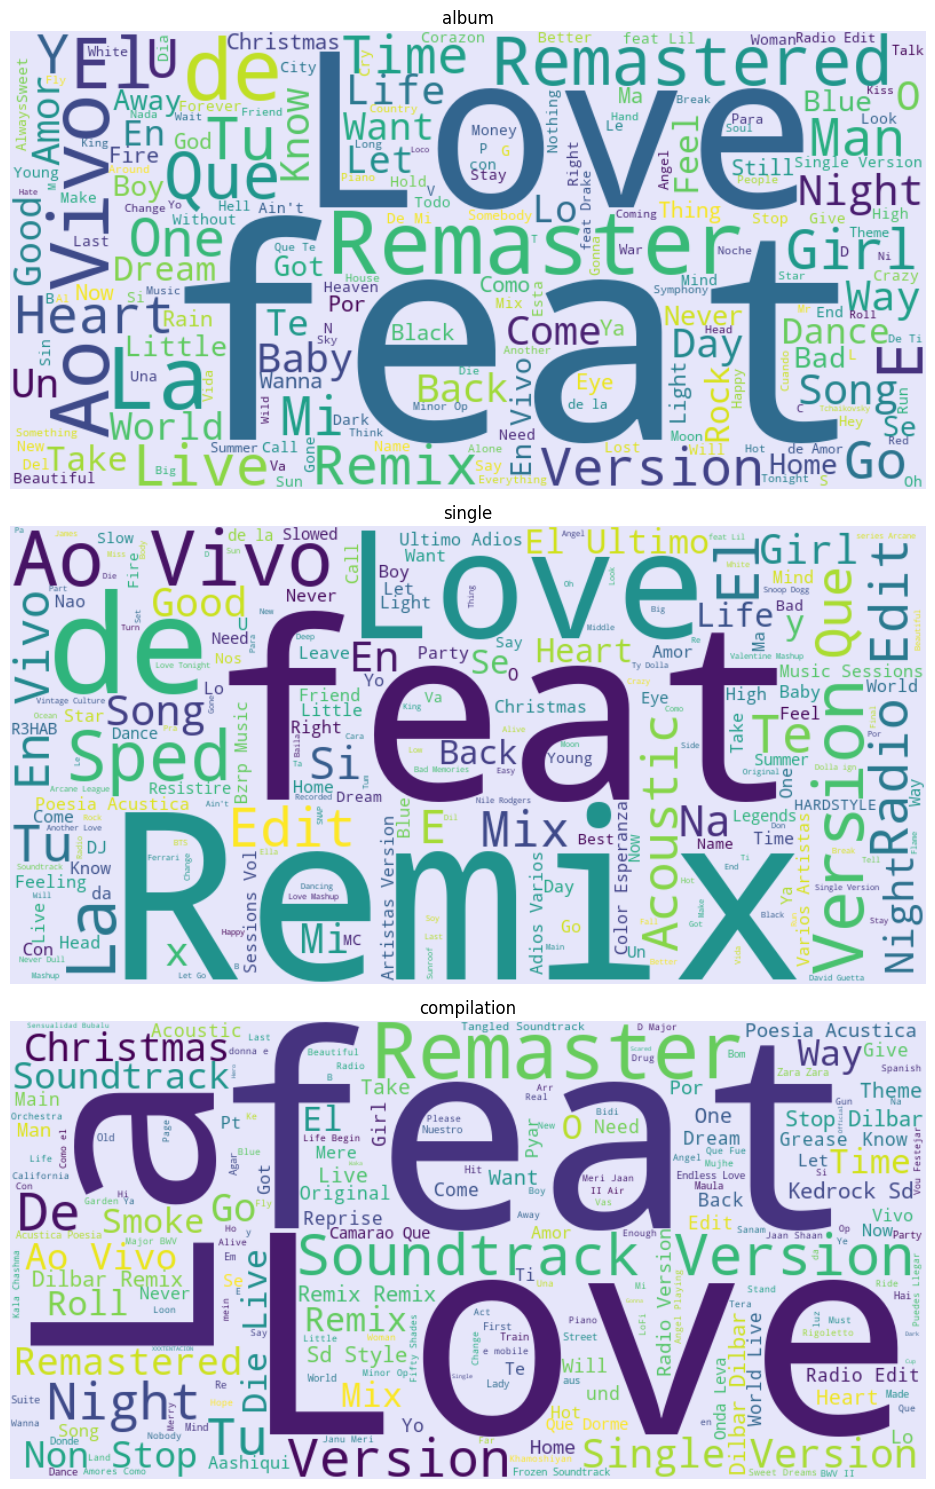

In [27]:
def wordclouds(df, genre_column='Album_type', track_column='Track', save_dir=None):
    """Generates and displays word clouds for each unique genre in a DataFrame, handling empty track names.

    Args:
        df: The input Pandas DataFrame.
        genre_column: The name of the column containing genre information.
        track_column: The name of the column containing track names.
        save_dir (str, optional): Directory to save the plot. If None, the plot is not saved. Defaults to None.

    Returns:
        None.
    """
    if not isinstance(df, pd.DataFrame):
        print("Error: Input must be a Pandas DataFrame.")
        return

    
    df = df[df[track_column].astype(str).str.strip() != '']

    unique_genres = df[genre_column].unique()
    fig, axes = plt.subplots(len(unique_genres), 1, figsize=(10, 5 * len(unique_genres)))

    for i, genre in enumerate(unique_genres):
        text = ' '.join(df[df[genre_column] == genre][track_column])
        wordcloud = WordCloud(width=800, height=400, background_color='lavender').generate(text)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(genre)

    plt.tight_layout()

    if save_dir:
        save_path = os.path.join(save_dir, 'wordclouds.png')
        plt.savefig(save_path)
        print(f"Saved to: {save_path}")

    plt.show()
    plt.close()

wordclouds(df, genre_column='Album_type', track_column='Track', save_dir=PLOT_DIR)